In [1]:
# citations of orignals:
# """
# first two attempts were DCGANs (result were mode collapse)
# MNIST DCGAN by TensorFlow Authors: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb#scrollTo=ZBwyU6t2Wf3g
# Monet_ Dataset DCGAN architecture: https://www.kaggle.com/code/thuylinh225/generate-monet-images-using-dcgan
# naming convention for models: https://github.com/thashimoto1998/DCGAN/blob/master/dcgan.py
#
# third attempt is WGAN-GP (better results)
# WGAN-GP video: https://www.youtube.com/watch?v=pG0QZ7OddX4&list=PLhhyoLH6IjfwIp8bZnzX8QR30TRcHO8Va&index=5
# WGAN-GP paper: https://arxiv.org/abs/1704.00028
# WGAN-GP github: https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs/4.%20WGAN-GP
# """

In [2]:
###############################
###         Updates         ###
###############################

#removed text cells
# added WGAN-GP

## fig = plt.figure(figsize=(10, 10))


In [3]:
import glob
import imageio
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
import matplotlib.image as mpimg

from IPython import display
from IPython.display import HTML
import zipfile
import re
from PIL import Image
import shutil
import matplotlib.animation as animation

In [4]:
import pandas as pd
from torchvision.transforms import v2
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import ReLU, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam

In [5]:
#for WGAN-GP
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [6]:
!pip install tensorflow_docs
import tensorflow_docs.vis.embed as embed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 2.1 MB/s eta 0:00:00


In [7]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except Exception as e:
    print("can't initialize tpu, using default, exception: " + str(e))
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

can't initialize tpu, using default, exception: Please provide a TPU Name to connect to.
Number of replicas: 1


In [8]:
#Gather images
!git clone https://github.com/LyJacky/ImageGeneration.git

Cloning into 'ImageGeneration'...
remote: Enumerating objects: 366, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 366 (delta 24), reused 61 (delta 24), pack-reused 305
Receiving objects: 100% (366/366), 30.18 MiB | 13.61 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [9]:
# files = glob.glob(f"/content/ImageGeneration/monet_jpg/*.jpg")
data_path = glob.glob(f"/content/ImageGeneration/monet_jpg")

os.chdir(data_path[0])

data  = []
for file in os.listdir():
    if file.endswith(".jpg"):
        file_path = f"{data_path[0]}/{file}"
        img = mpimg.imread(file_path)
        data.append(img)

In [10]:
print(len(data))
print(data[0].shape)

300
(256, 256, 3)


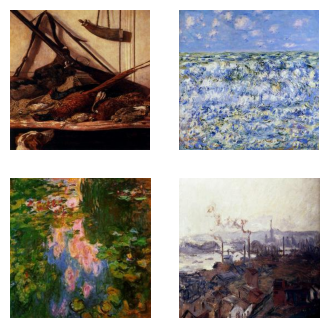

In [11]:
# show some samples

fig = plt.figure(figsize=(4,4))
for i, img in enumerate(data[0:4]):
    plt.subplot(2, 2, i+1)
    plt.imshow(data[i])
    plt.axis('off')
plt.show()

In [12]:
# # normalizing the images to [-1, 1]
# def normalize(image):
#   image = tf.cast(image, tf.float32)
#   image = (image / 127.5) - 1
#   return image

In [13]:
# def augment(image):
#   # image = tf.image.resize(image,[])
#   image = tf.image.random_flip_left_right(image)
#   image = tf.image.random_crop(image)
#   image = tf.image.random_brightness(image)
#   image = tf.image.random_saturation(image)
#   return image

In [14]:
# for val in data:
#   val = normalize(val)

#   # val = tf.image.resize(val, [,])
#   val = tf.image.random_flip_left_right(val)
#   val = tf.image.random_flip_up_down(val)
#   val = tf.image.random_brightness(val, 0.2)
#   # plt.imshow(val)
#   # plt.axis('off')
#   # plt.show()

#   # val = augment(val)


In [15]:
print(len(data))
print(data[0].shape)

300
(256, 256, 3)


In [16]:
# # show some samples
# plt.imshow(data[59])
# plt.axis('off')
# plt.show()

In [17]:
BATCH_SIZE = 64
BUFFER_SIZE = 300

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset)

<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.uint8, name=None)>


In [19]:
# modified generator

def make_generator_model():

    generator = Sequential(name="Generator")
    generator.add(Dense(16*16*512,
                        input_shape=(100,)))
    generator.add(Reshape((16,16,512)))

    # layer 2
    generator.add(Conv2DTranspose(filters=256, kernel_size=(6,6), strides=(2,2), padding='same'))
    generator.add(LeakyReLU(alpha=0.2))

    #layer 3
    generator.add(Conv2DTranspose(filters=128, kernel_size=(6,6), strides=(2,2), padding='same'))
    generator.add(LeakyReLU(alpha=0.2))

    #layer 4
    generator.add(Conv2DTranspose(filters=64, kernel_size=(6,6), strides=(2,2), padding='same'))
    generator.add(LeakyReLU(alpha=0.2))

    #layer 5
    generator.add(Conv2DTranspose(filters=32, kernel_size=(6,6), strides=(2,2), padding='same'))
    generator.add(LeakyReLU(alpha=0.2))

    #output
    generator.add(Conv2DTranspose(3, kernel_size=(6,6), activation='tanh', strides=(1,1), padding='same'))

    return generator

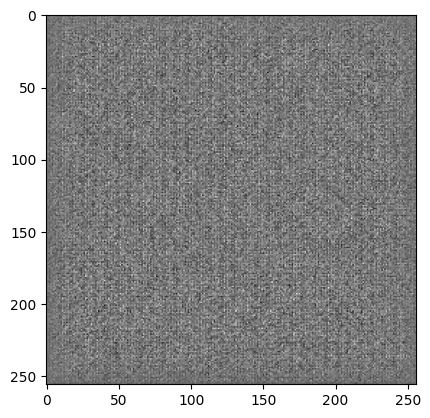

In [20]:
# create noisy image sample
with strategy.scope():
    generator = make_generator_model()
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [21]:
# Discriminator
def make_discriminator_model():

    discriminator = Sequential()

    #layer 1
    discriminator.add(Conv2D(filters=32, kernel_size=(6,6), strides=(2, 2), padding='same', input_shape=[256, 256, 3]))
    discriminator.add(LeakyReLU(0.2))

    #layer 2
    discriminator.add(Conv2D(filters=64, kernel_size=(6,6), strides=(2, 2), padding='same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))

    #layer 3
    discriminator.add(Conv2D(filters=128, kernel_size=(6,6), strides=(2, 2), padding='same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))

    #layer 4
    discriminator.add(Conv2D(filters=256, kernel_size=(6,6), strides=(2, 2), padding='same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))

    # Flatten and Output Layers
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(1, activation='sigmoid'))
    # discriminator.add(Dense(1, activation='binary_crossentropy'))

    return discriminator


In [22]:
with strategy.scope():
    discriminator = make_discriminator_model()
    decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49998367]], shape=(1, 1), dtype=float32)


In [23]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [24]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [25]:
with strategy.scope():
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [26]:
checkpoint_dir = '/content/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [28]:
!mkdir ../outputs
!mkdir ../outputs/first-DCGAN

In [138]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  # print(len(predictions))
  # print(type(predictions))
  # print(predictions.shape)

  # print("\n")
  # print(len(predictions[0]))
  # print(type(predictions[0]))
  # print(predictions.shape[0])
  # print("\n")

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      normalized_pred = predictions[i].numpy()

      # print(len(normalized_pred))
      # print(type(normalized_pred))
      # print(normalized_pred.shape)
      # print(normalized_pred)

      normalized_pred = (normalized_pred[:, :, :] * 127.5 + 127.5).astype(np.uint8)

      # print(len(normalized_pred))
      # print(type(normalized_pred))
      # print(normalized_pred.shape)
      # print(normalized_pred)

      plt.subplot(4, 4, i+1)
      plt.imshow(normalized_pred)

      # print("\n----------------------------------------------------------")

      plt.axis('off')

  plt.savefig('../outputs/first-DCGAN/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [31]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    # display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    # Debug: seed is Seed: tf.Tensor(2D rand num, shape(16,100))

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  # display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [32]:
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [49]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [50]:
#training loop
EPOCHS = 100

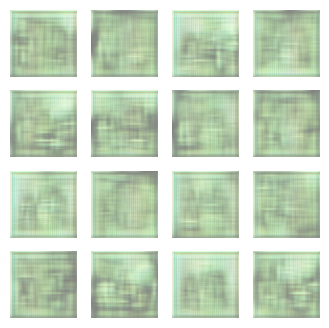

Time for epoch 1 is 4.967572927474976 sec


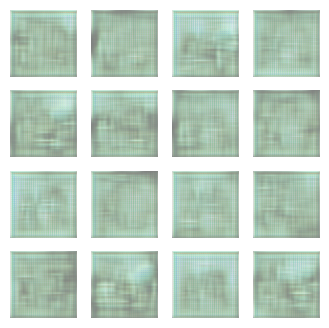

Time for epoch 2 is 4.918680191040039 sec


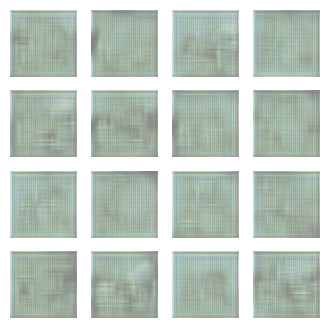

Time for epoch 3 is 5.267634630203247 sec


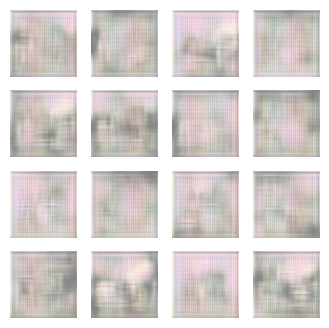

Time for epoch 4 is 5.281126976013184 sec


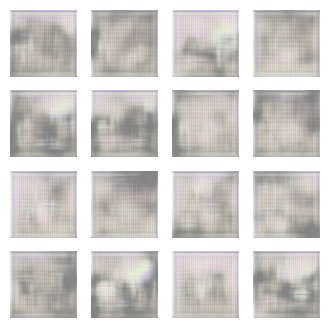

Time for epoch 5 is 4.92901349067688 sec


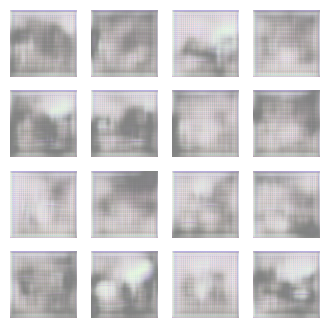

Time for epoch 6 is 4.953627586364746 sec


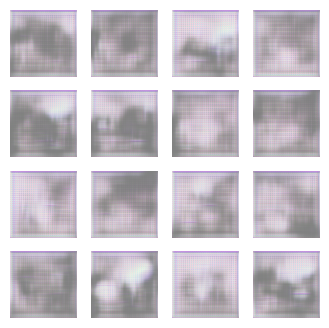

Time for epoch 7 is 4.937354564666748 sec


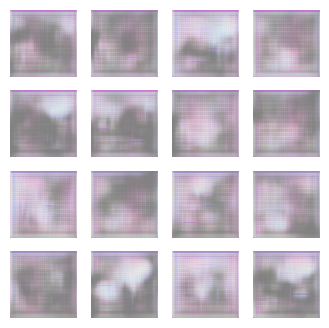

Time for epoch 8 is 5.276183843612671 sec


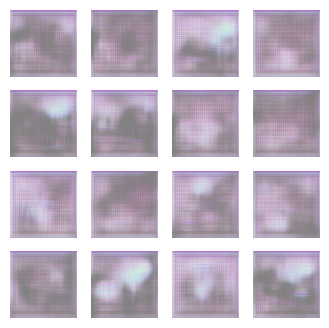

Time for epoch 9 is 5.3033952713012695 sec


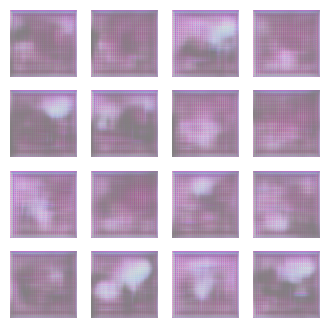

Time for epoch 10 is 5.129234790802002 sec


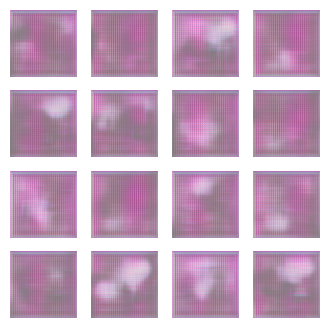

Time for epoch 11 is 5.197407245635986 sec


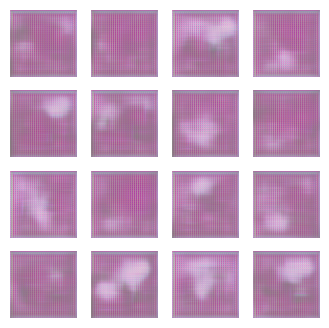

Time for epoch 12 is 4.87296462059021 sec


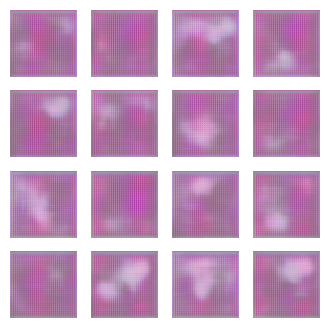

Time for epoch 13 is 4.8948891162872314 sec


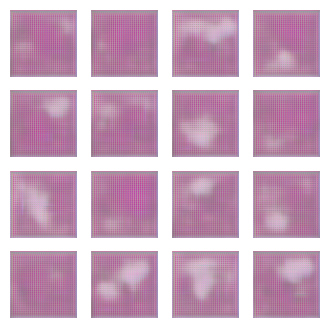

Time for epoch 14 is 4.87394118309021 sec


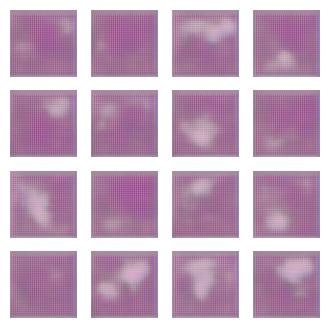

Time for epoch 15 is 6.611722946166992 sec


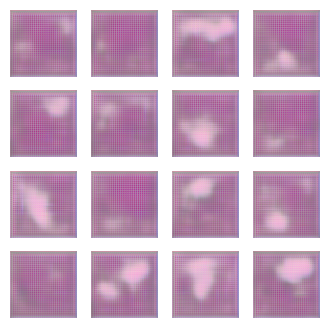

Time for epoch 16 is 4.923381090164185 sec


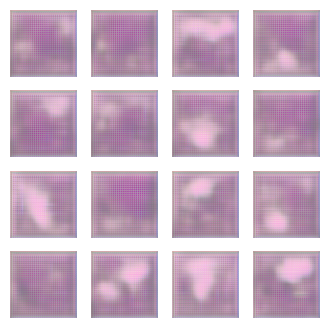

Time for epoch 17 is 4.8684210777282715 sec


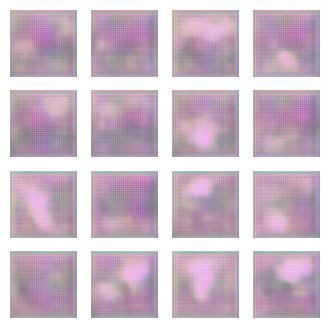

Time for epoch 18 is 5.486513614654541 sec


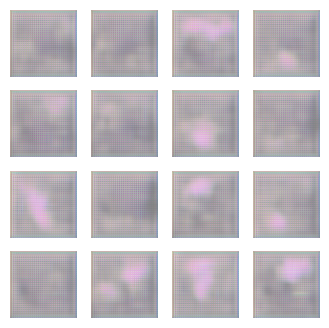

Time for epoch 19 is 4.8785080909729 sec


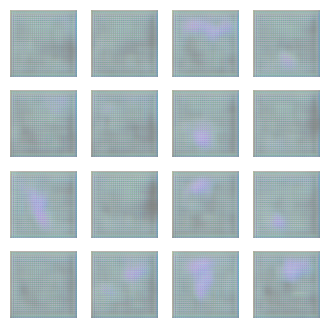

Time for epoch 20 is 4.907460689544678 sec


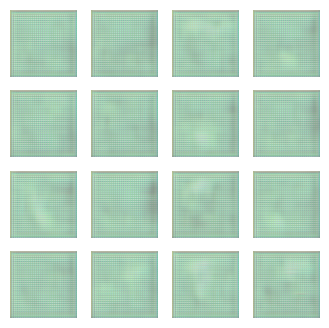

Time for epoch 21 is 5.276678800582886 sec


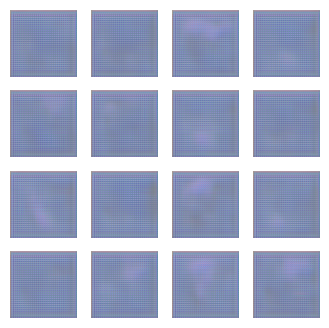

Time for epoch 22 is 6.616403102874756 sec


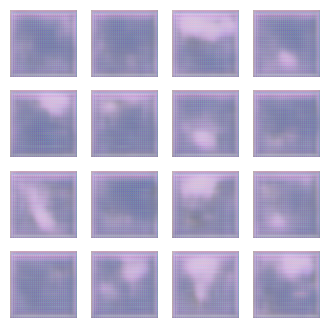

Time for epoch 23 is 5.0304179191589355 sec


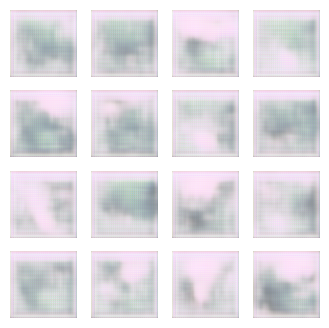

Time for epoch 24 is 4.940359115600586 sec


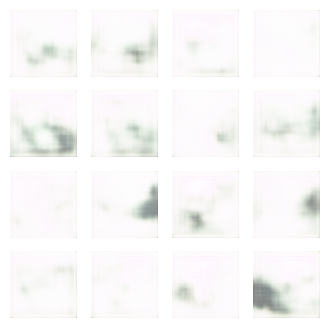

Time for epoch 25 is 4.890599727630615 sec


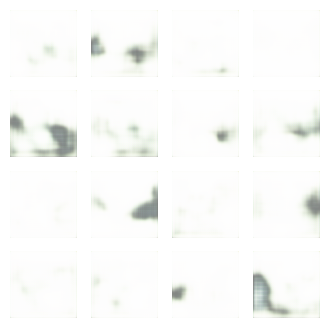

Time for epoch 26 is 5.449108839035034 sec


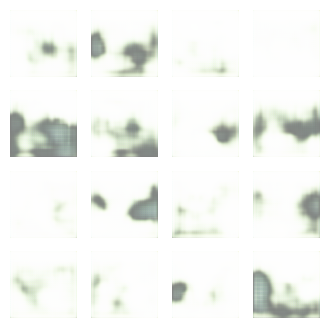

Time for epoch 27 is 5.297179937362671 sec


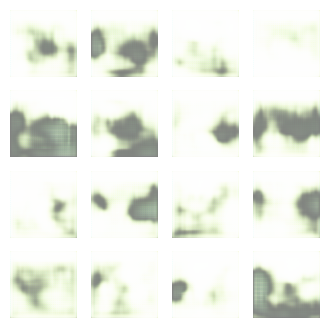

Time for epoch 28 is 4.912890195846558 sec


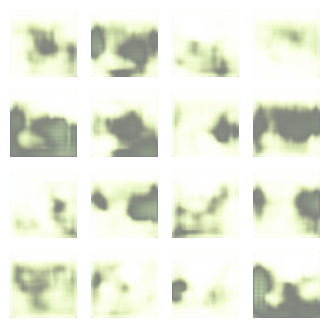

Time for epoch 29 is 5.224038362503052 sec


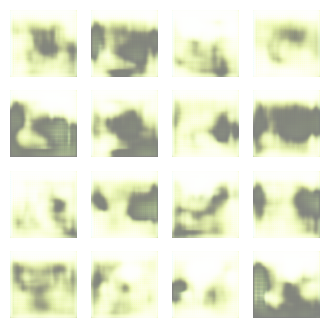

Time for epoch 30 is 5.670440196990967 sec


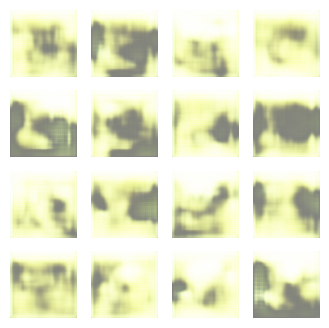

Time for epoch 31 is 4.9018943309783936 sec


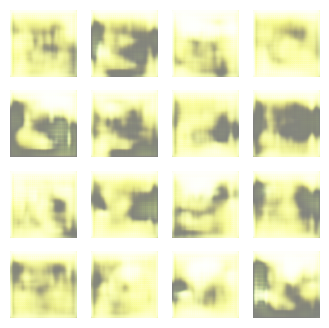

Time for epoch 32 is 5.3014256954193115 sec


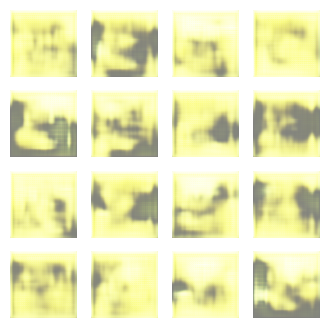

Time for epoch 33 is 4.915443658828735 sec


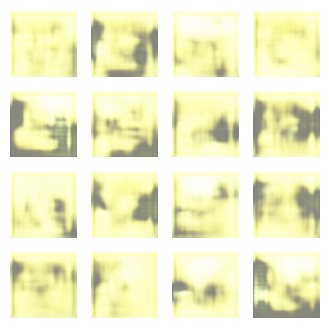

Time for epoch 34 is 4.9246978759765625 sec


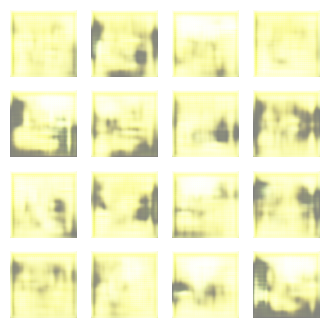

Time for epoch 35 is 4.9024670124053955 sec


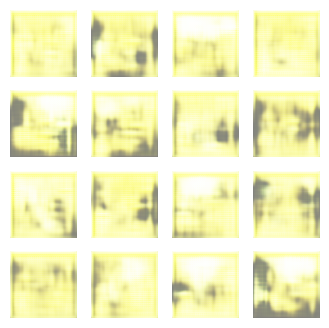

Time for epoch 36 is 5.270756721496582 sec


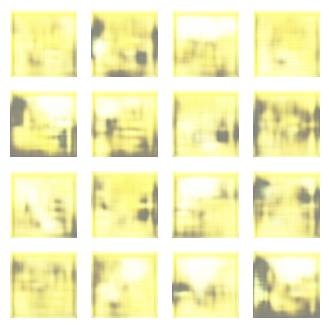

Time for epoch 37 is 4.905293226242065 sec


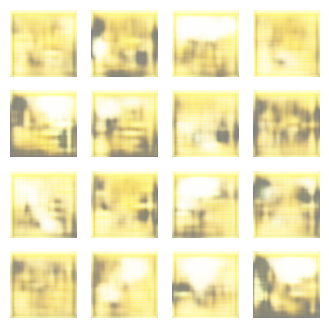

Time for epoch 38 is 5.355981111526489 sec


In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
first_dcgan_file = 'first_dcgan.gif'

with imageio.get_writer(first_dcgan_file, mode='I') as writer:
  filenames = glob.glob('../outputs/first-DCGAN/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
embed.embed_file(first_dcgan_file)

In [ ]:
#############################
###    2nd DCGAN Attempt  ###
#############################

In [ ]:
generator2 = make_generator_model()
discriminator2 = make_discriminator_model()
with strategy.scope():
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

noise_dim = 100
num_examples_to_generate = 16
# seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
!mkdir ../outputs/second-DCGAN

In [ ]:
class DCGAN_model:
    def __init__(self, noise_dim, EPOCHS, BATCH_SIZE, generator, discriminator, dataset):
        self.noise_dim = noise_dim
        self.EPOCHS = EPOCHS
        self.BATCH_SIZE = BATCH_SIZE
        self.generator = generator
        #self.discriminator = discriminator2
        self.dataset = dataset

    @tf.function
    def train(self, images):

    # Create random noise vector
        noise = tf.random.normal([images.shape[0], noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        # generate images use random noise vector
            generated_images = self.generator(noise, training=True)

            # use discriminator to evaluate the real and fake images
            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)
            self.debug(real_output, fake_output)

            # compute generator loss and discriminator loss
            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

            # Compute gradients
            gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            # Update optimizers
            generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        return (gen_loss + disc_loss) * 0.5

    def debug(self, real_output, fake_output):
        print("\t Discrimator real_output: ", real_output)
        print("\t Discrimator fake_output: ", fake_output)

    @tf.function
    def distributed_train(self, images):
        per_replica_losses = strategy.run(self.train, args=(images,))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)

    def generate_images(self):
        noise = tf.random.normal([self.BATCH_SIZE, self.noise_dim])
        predictions = self.generator.predict(noise)
        return predictions

    def generate_and_plot_images(self):
        image = self.generate_images()
        gen_imgs = 0.5 * image + 0.5
        # fig = plt.figure(figsize=(10, 10))
        fig = plt.figure(figsize=(5, 5))
        for i in range(25):
            plt.subplot(5, 5, i+1)
            plt.imshow(gen_imgs[i, :, :, :])
            plt.axis('off')
        plt.show()

    def save_images_with_seed_for_gif(self):
        predictions = self.generator.predict(seed)

        gen_imgs = 0.5 * predictions + 0.5
        # fig = plt.figure(figsize=(10, 10))
        fig = plt.figure(figsize=(5, 5))
        for i in range(25):
            plt.subplot(5, 5, i+1)
            plt.imshow(gen_imgs[i, :, :, :])
            plt.axis('off')
            plt.savefig('../outputs/second-DCGAN/image_at_epoch_{:04d}.png'.format(epoch))

    def train_loop(self):
        e_ls = []
        mean_ls = []
        for epoch in range(self.EPOCHS):
            start = time.time()

            total_loss = 0.0
            num_batches = 0

            for image_batch in self.dataset:
                loss = self.distributed_train(image_batch)
                total_loss += tf.reduce_mean(loss)
                num_batches += 1
            mean_loss = total_loss / num_batches

            if (epoch+1) % 5 == 0:
                self.save_images_with_seed_for_gif()

            if (epoch+1) % 10 == 0:
                print ('Time for epoch {} is {} sec, mean loss is {}'.format(epoch + 1, time.time()-start, mean_loss))
                self.generate_and_plot_images()

                e_ls.append(epoch+1)
                mean_ls.append(mean_loss)
        print("\nMean Loss for every 20 epochs: \n")
        table = pd.DataFrame({"Epoch": e_ls, "Mean Loss": np.array(mean_ls)})
        return table

In [ ]:
#training loop
EPOCHS = 100

In [ ]:
# # train, visualize and print out the result for DCGAN model
# gan1 = DCGAN_model(noise_dim, EPOCHS, BATCH_SIZE, generator2, discriminator2, train_dataset)
# res1 = gan1.train_loop()
# res1

In [ ]:
# res1

In [ ]:
# gan1.generate_and_plot_images()

In [ ]:
second_dcgan_file = 'second_dcgan.gif'

with imageio.get_writer(second_dcgan_file, mode='I') as writer:
  filenames = glob.glob('../outputs/second-DCGAN/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
embed.embed_file(second_dcgan_file)

In [ ]:
#############################
###    WGAN-GP Attempt    ###
#############################

In [ ]:
"""
dataset = datasets.

- change cpu in gradient_penalty?
- different learning rates for disc, gen
- image size???
"""

In [ ]:
def gradient_penalty(disc, real, fake, device="cpu"):
  BATCH_SIZE, C, H, W = real.shape
  epsilon = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
  interpolated_images = real * epsilon + fake * (1 - epsilon)

  # calcuate discriminator scores
  mixed_scores = disc(interpolated_images)

  gradient = torch.autograd.grad(
      inputs = interpolated_images,
      outputs = mixed_scores,
      grad_outputs = torch.ones_like(mixed_scores),
      create_graph = True,
      retain_graph = True,
  )[0]

  gradient = gradient.view(gradient.shape[0], -1)
  gradient_norm = gradient.norm(2, dim=1)
  gradient_penalty = torch.mean((gradient - 1) ** 2)
  return gradient_penalty


In [ ]:
class Discriminator(nn.Module):
  def __init__(self, channels_img, features_d):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        nn.Conv2d(channels_img, features_d, kernel_size = 4, stride = 2, padding = 1),
        nn.LeakyReLU(0.2),

        #_block(in_channels, out_channels, kernel_size, stride, padding)
        self._block(features_d, features_d * 2, 4, 2, 1),
        self._block(features_d * 2, features_d * 4, 4, 2, 1),
        self._block(features_d * 4, features_d * 8, 4, 2, 1),

        # output is 4x4 (Conv2d turns into 1x1)
        nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0)
    )
  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        # nn.BatchNorm2d(out_channels),
        nn.InstanceNorm2d(out_channels, affine=True),
        nn.LeakyReLU(0.2),
    )

  def forward(self, x):
    return self.disc(x)

In [ ]:
class Generator(nn.Module):
  def __init__(self, channels_noise, channels_img, features_g):
    super(Generator, self).__init__()
    self.net = nn.Sequential(
        self._block(channels_noise, features_g * 16, 4, 1, 0),
        self._block(features_g * 16, features_g * 8, 4, 2, 1),
        self._block(features_g * 8, features_g * 4, 4, 2, 1),
        self._block(features_g * 4, features_g * 2, 4, 2, 1),
        nn.ConvTranspose2d(
            features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
        ),
        nn.Tanh(),
    )
  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

  def forward(self, x):
    return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"


In [ ]:
import torchvision.transforms as transforms


In [ ]:
# hyperparameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
LEARNING_RATE = 1e-4
# DISCRIMINATOR_LEARNING_RATE = 5e-5
# GENERATOR_LEARNING_RATE = 5e-5
BATCH_SIZE = 32
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
FEATURES_DISC = 64
FEATURES_GEN = 64
DISC_ITERATIONS = 5
LAMBDA_GP = 10

transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

In [ ]:
# checkpoints

def save_checkpoints(state, filename="monet_wgan_gp.pth.tar"):
  print("=> Saving checkpoint")
  torch.save(state, filename)

def load_checpoint(checkpoint, gen, disc):
  print("=> Loading checkpoint")
  gen.load_state_dict(checkpoint['gen'])   # generator
  disc.load_state_dict(checkpoint['disc']) # discriminator

In [ ]:
def wgan_generate_images():
    noise = tf.random.normal([BATCH_SIZE, Z_DIM])
    # predictions = gen.predict(noise)
    fake = gen(noise)
    return fake

def wgan_generate_and_plot_images():
    image = wgan_generate_images()
    gen_imgs = 0.5 * image + 0.5
    fig = plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(gen_imgs[i, :, :, :])
        plt.axis('off')
    plt.show()

In [ ]:
!rm -r ../ImageGeneration/
!rm -r ../.ipynb_checkpoints/
!rm -r ../.git/

In [ ]:
# !ls -a

In [ ]:
# make sure to not have image_at_epoch_0010.jpg in the folder

dataset = datasets.ImageFolder(root="/content/ImageGeneration/", transform=transforms) #this line takes long
# dataset = datasets.ImageFolder



dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
# opt_gen = optim.Adam(gen.parameters(), lr=GENERATOR_LEARNING_RATE, betas=(0.0, 0.9))
# opt_disc = optim.Adam(disc.parameters(), lr=DISCRIMINATOR_LEARNING_RATE, betas=(0.0, 0.9))

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

In [ ]:
print(len(dataset))
print(len(dataset[0]))
print((dataset[0][0]), "\n")
print((dataset[0][0][0]), "\n")
print((dataset[0][0][0][0]), "\n")

In [ ]:
# show some samples
plt.imshow(dataset[1][0][2])
plt.axis('off')
plt.show()

In [ ]:
gen.train()
disc.train()

In [ ]:
EPOCHS = 5

In [ ]:
noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
fake = gen(noise)

image_to_display = fake.cpu().detach().numpy()
print(image_to_display)
# image_to_display = image_to_display.transpose(0, 1, 2, 3)
plt.imshow(image_to_display[0][0])
plt.axis('off')

In [ ]:
for epoch in range(EPOCHS):
  for batch_idx, (real_img, _) in enumerate(dataloader):
    real = real_img.to(device)
    if len(real) < 32: # sometimes had tensor of size 12
        break

    for _ in range(DISC_ITERATIONS):

      noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
      fake = gen(noise)
      disc_real = disc(real).reshape(-1)
      disc_fake = disc(fake).reshape(-1)
      gp = gradient_penalty(disc, real, fake, device=device)
      loss_disc = (
          -(torch.mean(disc_real) - torch.mean(disc_fake)) + LAMBDA_GP*gp
      )
      disc.zero_grad()
      loss_disc.backward(retain_graph=True)
      opt_disc.step()

    output = disc(fake).reshape(-1)
    loss_gen = -torch.mean(output)
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()

    if batch_idx % 3 == 0:
      print(
          f"EPOCH [{epoch}/{EPOCHS}] Batch {batch_idx}/{len(dataloader)} Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
      )

      ## show real and fake
      # if real
      # image_to_display = real_img.numpy()
      # image_to_display = image_to_display.transpose(0, 1, 2, 3)
      # plt.imshow(image_to_display[0][0])
      # plt.axis('off')
      # plt.show()

      # else:
      # fake = gen(fixed_noise)
      image_to_display = fake.cpu().detach().numpy()
      # image_to_display = image_to_display.transpose(0, 1, 2, 3)
      plt.imshow(image_to_display[0][0])
      plt.axis('off')
      plt.show()

      # with torch.no_grad():
      #     fake = gen(fixed_noise)
      #     img_grid_real = torchvision.utils.make_grid(
      #       real[:32], normalize=True
      #     )
      #     img_grid_fake = torchvision.utils.make_grid(
      #       fake[:32], normalize=True
      #     )
      #     writer_real.add_image("Real", img_grid_real, global_step=step)
      #     writer_fake.add_image("Fake", img_grid_fake, global_step=step)
      step += 1

In [ ]:
      #  device='cuda:0') len(real) 12

# device='cuda:0', grad_fn=<TanhBackward0>) len(fake):  32